In [1]:
import pandas as pd
import os
import geopandas as gpd

home_dir = "/scratch/hydro4/shared_data/uk_catchment_data/camels_gb_v2/"
# os.listdir(home_dir)

# CAMELS-GB_v2

This dataset provides catchment boundaries, hydro-meteorological timeseries and landscape attributes for 671 catchments across Great Britain.

    – Includes: river flows, river levels, groundwater levels, precipitation, potential evapotranspiration and temperature time series
    – Daily hydro-meteorological timeseries from 1970 to 2022 (streamflow, PET, rainfall, temperature).
    – Hourly hydro-meteorological timeseries from 1990 to 2022 (rainfall, riverflow)
    – Catchment characteristics: land cover, hydrometry, human influences, location, topography, climate, hydrology, soils and hydrogeology
    – Hydrologic signatures: quantitative, statistical, or dynamical metrics which charac-terise a catchment’s physical behaviour
    
It is described in detailed at: https://essd.copernicus.org/preprints/essd-2025-608/

## Understanding where the data covers

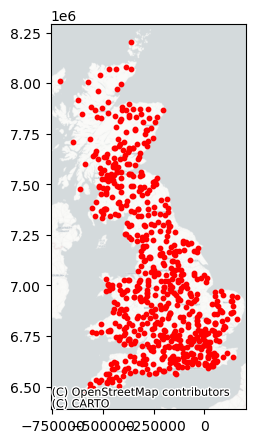

In [48]:
topography = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_topographic_attributes.csv")
gauge_locs = topography[['gauge_id', 'gauge_name', 'gauge_lat', 'gauge_lon']]

from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

geometry = [Point(xy) for xy in zip(gauge_locs.gauge_lon, gauge_locs.gauge_lat)]
gauge_locs = gauge_locs.drop(['gauge_lon', 'gauge_lat'], axis=1)
gauge_locs_gdf = GeoDataFrame(gauge_locs, crs="EPSG:4326", geometry=geometry)

# Need to add first so contextily knows which basemap to plot
gauge_locs_3857 = gauge_locs_gdf.to_crs(epsg=3857)
# nrfa_3857 = nrfa.to_crs(epsg=3857)

fig,ax=plt.subplots(figsize=(5,5))
gauge_locs_3857.plot(ax=ax, markersize=10, color="red")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
# nrfa_3857.plot(ax=ax, color = 'None', linewidth= 0.5)

# Understanding the hydrological signatures
Describe the concept of the signatures  
Describe the kinds of things measured there.  
Maybe do some spatial plots (hopefully) showing a spatial gradient in some of the values.

In [3]:
hydrologic_attributes = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_hydrologic_attributes.csv")
hydrologic_attributes.head()

,gauge_id,q_mean,runoff_ratio,stream_elas,slope_fdc,baseflow_index,baseflow_index_ceh,hfd_mean,Q5,Q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq
0,10002,1.31,0.56,1.19,1.94,0.66,0.63,130.50,0.32,3.50,2.15,1.32,6.41,7.52,0.0
1,10003,1.32,0.55,1.37,1.95,0.72,0.73,136.53,0.32,3.36,0.99,1.39,8.64,9.71,0.0
2,1001,1.62,0.61,1.15,4.09,0.49,0.39,108.78,0.08,5.48,7.36,1.52,103.48,11.74,0.0
3,101002,0.90,0.38,1.26,1.49,0.68,0.66,135.31,0.25,2.47,3.48,1.22,3.46,5.00,0.0
4,101005,0.79,0.35,1.35,1.51,0.63,0.59,136.22,0.26,2.27,5.89,1.38,0.35,2.80,0.0


In [4]:
hydrologic_attributes_with_locs = pd.merge(gauge_locs_gdf, hydrologic_attributes)

In [5]:
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
uk = world[world["ADMIN"] == "United Kingdom"]
# Make sure CRS matches gauges
uk = uk.to_crs(gauge_locs_gdf.crs)

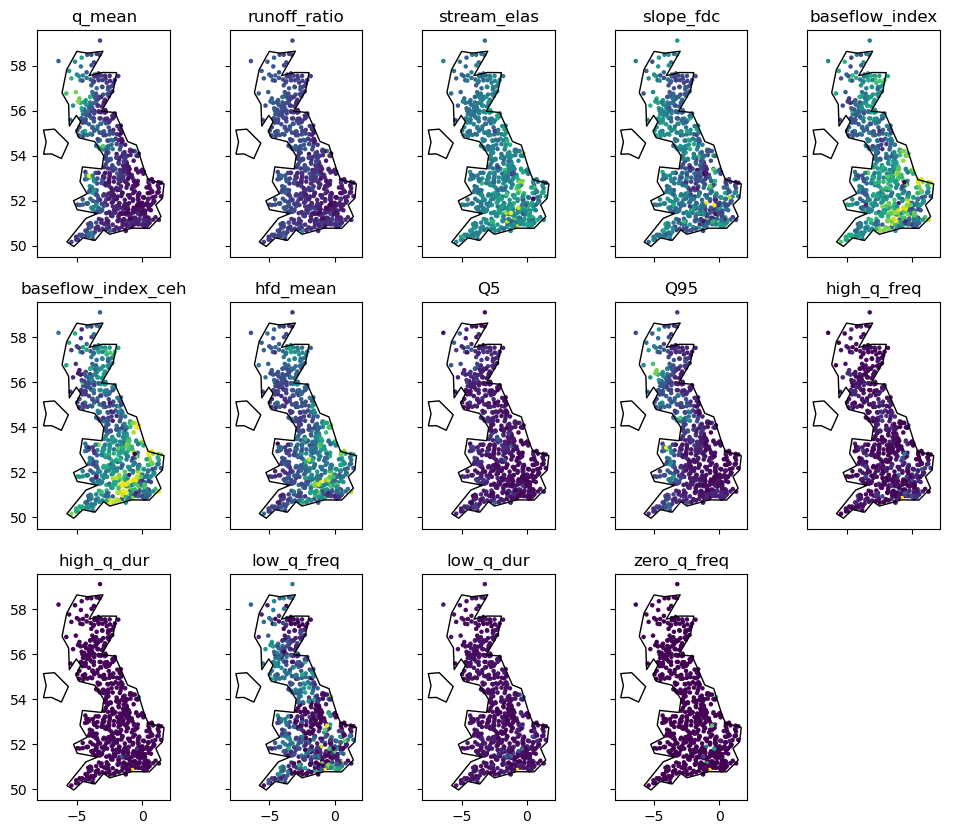

In [12]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(12,7), sharex=True, sharey=True) #wide, tall
axs=axs.flatten()
for ax_num, col in enumerate(hydrologic_attributes_with_locs.columns[3:]):
    uk.boundary.plot(ax=axs[ax_num], color="black", linewidth=1)
    hydrologic_attributes_with_locs.plot(ax=axs[ax_num],column=col,cmap="viridis", markersize=5, legend=False)
    axs[ax_num].set_title(col)
for ax in axs[len(hydrologic_attributes_with_locs.columns[3:]):]:
    ax.axis('off')

<Axes: >

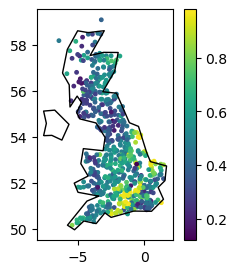

In [16]:
fig, ax = plt.subplots(figsize=(3,3))
uk.boundary.plot(ax=ax, color="black", linewidth=1)
hydrologic_attributes_with_locs.plot(ax=ax,column="baseflow_index_ceh",cmap="viridis",  markersize=6, legend=True)

# Relationship between flow and precipitation?

In [8]:
climatic_attributes = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_climatic_attributes.csv")
# test = pd.merge(hydrologic_attributes_with_locs.iloc[:,:4], climatic_attributes[['gauge_id', 'p_mean']])
test = pd.merge(hydrologic_attributes_with_locs, climatic_attributes[['gauge_id', 'p_mean']])

In [ ]:
## Follows roughly what we'd expect, but with some outliers We could then look into the outliers?

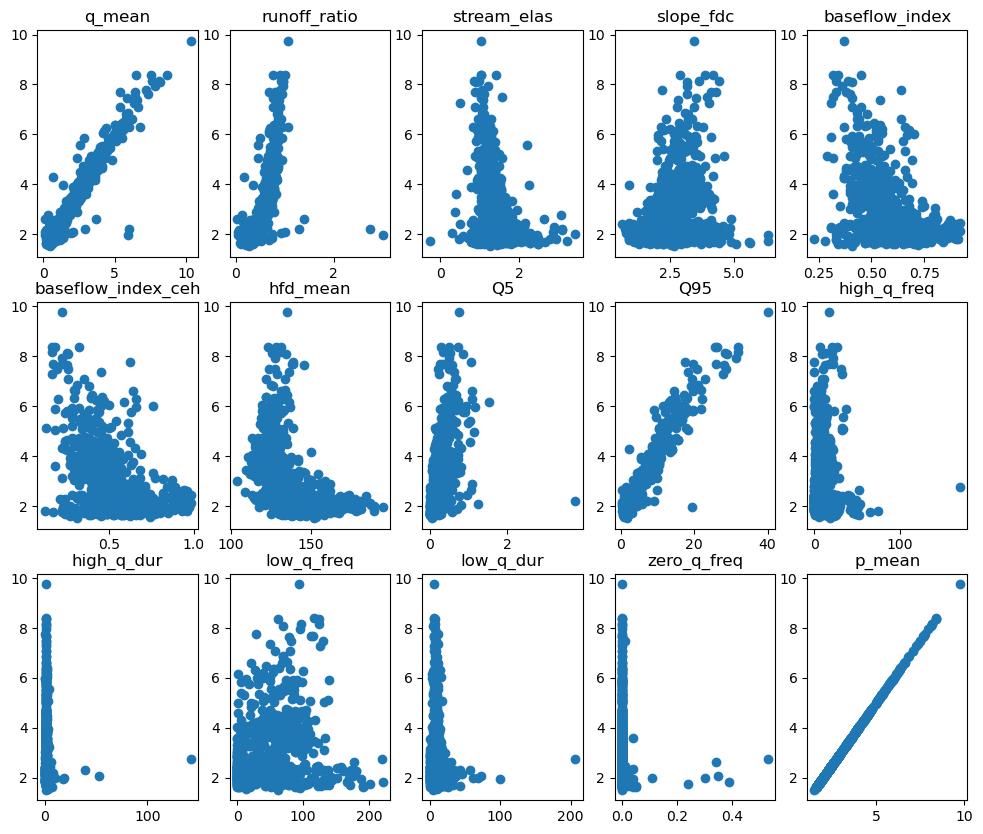

In [9]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(12,10)) #wide, tall
axs=axs.flatten()
for ax_num, col in enumerate(test.columns[3:]):
    axs[ax_num].scatter(test[col], test['p_mean']) 
    axs[ax_num].set_title(col)

## Building a model to predict the influence of catchment characteristics on runoff

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import multiprocessing
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import numpy as np

Deciding on the input variables

In [102]:
# The predictor variables
Xfull = topography.drop(['gauge_id', 'gauge_name', 'gauge_easting', 'gauge_northing'], axis =1)
Xfull = pd.DataFrame({'precip': climatic_attributes['p_mean']})
Xfull = climatic_attributes['p_mean']
# The variable to be predicted
Yfull = hydrologic_attributes['q_mean'].values

Train test split

In [103]:
X_train, X_test, y_train, y_test = train_test_split( Xfull, Yfull,test_size=0.2, random_state=42)

Fit a linear model

In [104]:
lin_model = Pipeline([("scaler", StandardScaler()),("model", LinearRegression())])
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

Fit a random forest model

In [83]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Fit XGB model

In [84]:
xgb_model = XGBRegressor( n_estimators=300,learning_rate=0.05,max_depth=4,subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

Evaluate model performance

In [53]:
def evaluate(y_true, y_pred):
    return {"R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)}

results = pd.DataFrame({"Linear Regression": evaluate(y_test, y_pred_lin),"Random Forest": evaluate(y_test, y_pred_rf),
    "XGBoost": evaluate(y_test, y_pred_xgb)})

print(results)

      Linear Regression  Random Forest   XGBoost
R2             0.717085       0.871520  0.863183
RMSE           0.870696       0.586755  0.605492
MAE            0.596100       0.391004  0.386352


In [85]:
def evaluate(y_true, y_pred):
    return {"R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)}

results = pd.DataFrame({"Linear Regression": evaluate(y_test, y_pred_lin),"Random Forest": evaluate(y_test, y_pred_rf),
    "XGBoost": evaluate(y_test, y_pred_xgb)})

print(results)

      Linear Regression  Random Forest   XGBoost
R2             0.886179       0.891547  0.910141
RMSE           0.552269       0.539087  0.490705
MAE            0.256195       0.270373  0.269901


In [86]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lin = LinearRegression()

r2_lin = cross_val_score(lin, Xfull, Yfull, cv=kf, scoring='r2')
rmse_lin = -cross_val_score(lin, Xfull, Yfull, cv=kf,
                            scoring='neg_root_mean_squared_error')

print("Linear Regression")
print("Mean R2:", r2_lin.mean())
print("Mean RMSE:", rmse_lin.mean())

Linear Regression
Mean R2: 0.9166472948366785
Mean RMSE: 0.4390420573545339


In [87]:
rf = RandomForestRegressor(random_state=42)

r2_rf = cross_val_score(rf, Xfull, Yfull, cv=kf, scoring='r2')
rmse_rf = -cross_val_score(rf, Xfull, Yfull, cv=kf,
                           scoring='neg_root_mean_squared_error')

print("Random Forest")
print("Mean R2:", r2_rf.mean())
print("Mean RMSE:", rmse_rf.mean())

Random Forest
Mean R2: 0.9236819761856422
Mean RMSE: 0.4305455055052585


In [88]:
xgb = XGBRegressor(random_state=42)

r2_xgb = cross_val_score(xgb, Xfull, Yfull, cv=kf, scoring='r2')
rmse_xgb = -cross_val_score(xgb, Xfull, Yfull, cv=kf,
                            scoring='neg_root_mean_squared_error')

print("XGBoost")
print("Mean R2:", r2_xgb.mean())
print("Mean RMSE:", rmse_xgb.mean())

XGBoost
Mean R2: 0.8988254122665392
Mean RMSE: 0.4948708345762788


 Feature importance (Random Forest)

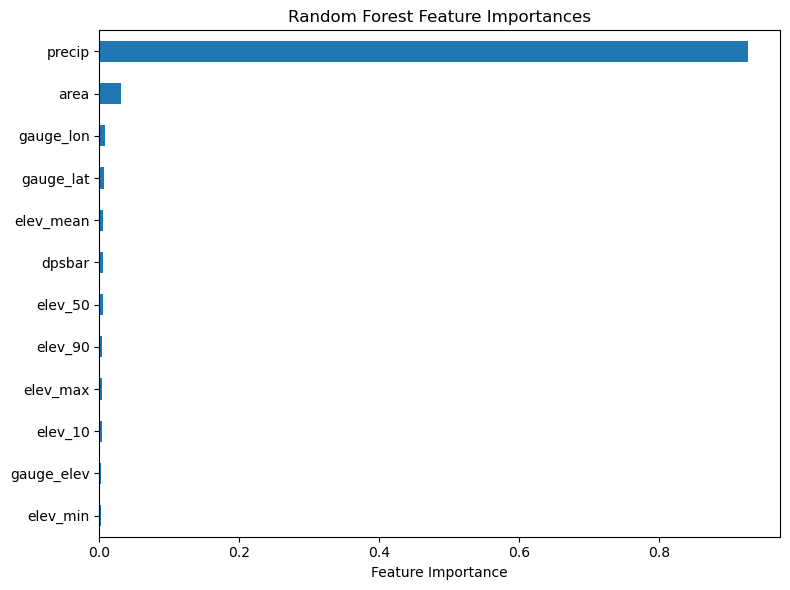

In [89]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500,random_state=42, n_jobs=-1)
rf.fit(Xfull, Yfull)
importances = pd.Series(rf.feature_importances_,index=Xfull.columns).sort_values(ascending=False)


plt.figure(figsize=(8, 6))
importances.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()

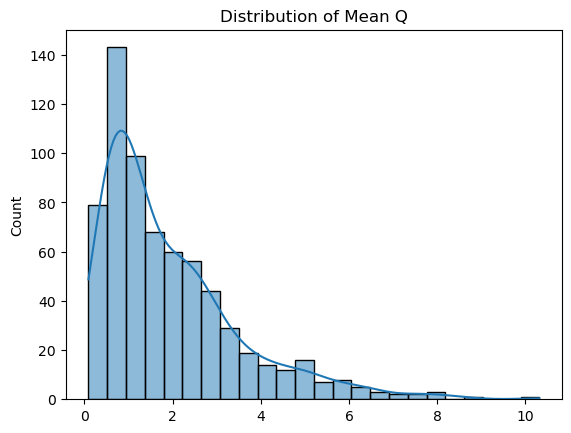

Skewness: 1.589289746830567


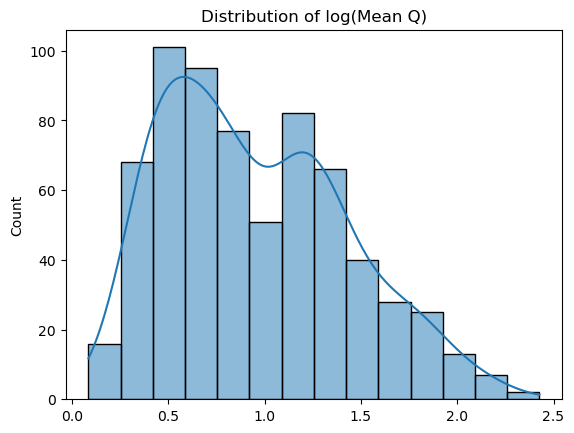

In [58]:
import seaborn as sns

sns.histplot(Yfull, kde=True)
plt.title("Distribution of Mean Q")
plt.show()

from scipy.stats import skew

print("Skewness:", skew(Yfull))

import numpy as np

sns.histplot(np.log1p(Yfull), kde=True)
plt.title("Distribution of log(Mean Q)")
plt.show()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xfull, Yfull, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred

In [63]:
rf_raw = RandomForestRegressor(random_state=42)
rf_raw.fit(X_train, y_train)
r2_raw = rf_raw.score(X_test, y_test)
y_pred_raw = rf_raw.predict(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rf_log = RandomForestRegressor(random_state=42)
rf_log.fit(X_train, y_train_log)

y_pred_log = rf_log.predict(X_test)
y_pred_back = np.expm1(y_pred_log)

r2_log = r2_score(y_test, y_pred_back)

print(r2_raw, r2_log)

rmse_raw = np.sqrt(mean_squared_error(y_test, y_pred_raw))
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_back))
print(r2_raw, r2_log)

0.8393826750829971 0.8217707875761211
0.8393826750829971 0.8217707875761211


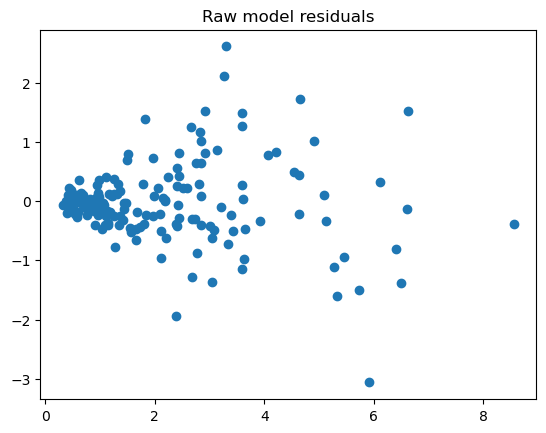

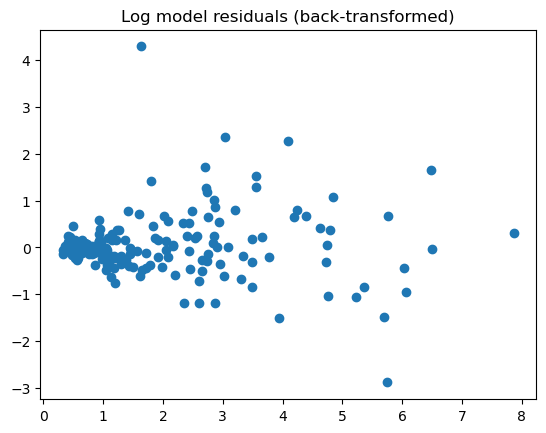

In [64]:
plt.scatter(y_pred_raw, y_test - y_pred_raw)
plt.title("Raw model residuals")
plt.show()

plt.scatter(y_pred_back, y_test - y_pred_back)
plt.title("Log model residuals (back-transformed)")
plt.show()


In [35]:
# Split data into training and test sets
X_train, X_temp, Y_train, Y_temp = \
    train_test_split(Xfull, Yfull, test_size=0.6666, random_state=123)
# Split off another training set now to train the hyperparameters using the two best models from above
X_validate, X_finaltest, Y_validate, Y_finaltest = \
    train_test_split(X_temp, Y_temp, test_size=0.5, random_state=123)

In [107]:
# climatic_attributes = pd.read_csv(home_dir + "Catchment_Timeseries/Hydro-Meteorological/Daily/CAMELS_GB_v2_hydromet_daily_timeseries_10002_19701001-20220930.csv")
# climatic_attributes.head()

In [61]:
# cachment_boundaries = gpd.read_file(home_dir + "Catchment_Boundaries/CAMELS_GB_v2_catchment_boundaries.shp")
# # cachment_boundaries.plot()

In [79]:
# nrfa = gpd.read_file("/scratch/hydro4/shared_data/uk_catchment_data/shapefile_boundaries/NRFACatchmentsAll-2024.shp")
# nrfa.plot(color = 'None', linewidth= 1)
# nrfa.crs